- Warning process

In [13]:
import warnings
warnings.filterwarnings('ignore')

- Load modules

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO, AlignIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor


- Auxiliar functions

In [137]:
def ploting_phylogenetic_tree(aligned_file, name_fig):
    alignment = AlignIO.read(aligned_file, "fasta")

    calculator = DistanceCalculator("blosum62")
    constructor = DistanceTreeConstructor()
    dm = calculator.get_distance(alignment)
    tree = constructor.nj(dm)

    clade_subtypes = {}
    label_list = []

    for clade in tree.find_clades():
        if clade.name:
            if clade.name.startswith("Inner"):
                clade.name = ""
            else:
                parts = clade.name.split("|")
                raw_name = f"{parts[0].strip()} {parts[1].strip()}" if len(parts) == 2 else parts[0]
                label = raw_name.replace("-", " ")
                label = label.replace("NA", "").replace("Alpha", "(Alpha)").replace("Beta", "(Beta)")

                subtype = parts[1].lower() if len(parts) > 1 else ""

                if "purpuratus" in label.lower():
                    clade.color = "#136f63"
                    clade_subtypes[label] = "#136f63"
                elif subtype == "alpha":
                    clade.color = "#d00000"
                    clade_subtypes[label] = "#d00000"
                elif subtype == "beta":
                    clade.color = "#3f88c5"
                    clade_subtypes[label] = "#3f88c5"
                else:
                    clade.color = "black"
                    clade_subtypes[label] = "black"

                clade.name = label
                label_list.append(label)

    fig = plt.figure(figsize=(14, 9))
    ax = fig.add_subplot(1, 1, 1)
    Phylo.draw(tree, do_show=False, axes=ax, show_confidence=False)

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Alpha', markerfacecolor="#d00000", markeredgecolor='black', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='Beta', markerfacecolor="#3f88c5", markeredgecolor='black', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='A. purpuratus', markerfacecolor="#136f63", markeredgecolor='black', markersize=8)
    ]

    ax.legend(handles=legend_elements, loc='lower right', title="Subtype", fontsize=12)
    ax.set_xlabel("Branch length", fontsize=14)
    ax.set_ylabel("Taxa", fontsize=14)

    sns.despine()
    plt.tight_layout()
    plt.savefig(name_fig, dpi=300)
    

In [90]:
def run_msa(aligned_file, fasta_file):
    clustalomega_cline = ClustalOmegaCommandline(
        infile=fasta_file, outfile=aligned_file, verbose=True, auto=True, force=True
    )
    print("Running alignment...")
    stdout, stderr = clustalomega_cline()

In [60]:
def get_subtype(description):
    description = description.upper()
    if "ALPHA" in description:
        return "Alpha"
    elif "BETA" in description:
        return "Beta"
    else:
        return "NA"

In [59]:
def get_organism(description):
    values = description.split("[")
    organism = values[1].split("]")[0].replace(" ", "-")
    return organism

In [52]:
def check_entres_to_ignore(description):

    description = description.upper()
    
    if "hypothetical" in description or "unnamed" in description or "LOW" in description or "partial" in description or "spatiotemporal" in description:
        return True
    else:
        return False


In [116]:
def prepare_sequences_for_MSA(dataset, sequence_input, id_seq, name_export):

    records = []

    for index in dataset.index:
        sequence = dataset["sequence"][index]
        id_accession = dataset["Accession"][index]
        list_organism = dataset["Organism"][index].split("-")
        organism = f"{list_organism[0][0]}.-{list_organism[1]}"
        subtype = dataset["Subtype"][index]
        id_sequence = f"[{id_accession}]-{organism}|{subtype}"

        records.append(SeqRecord(Seq(sequence), id=id_sequence, description=""))
    records.append(SeqRecord(Seq(sequence_input), id=id_seq, description=""))

    SeqIO.write(records, name_export, "fasta")

- Definitions and colors

In [34]:
personalized_pallete = ["#bee9e8", "#62b6cb", "#1b4965", 
                  "#cae9ff", "#5fa8d3"]

- Reading dataframe with statistics and descriptions of alignment result from BLAST

In [28]:
df_data = pd.read_csv(
    "../external_results_tools/4J6C457P013-Alignment-HitTable.csv", header=None)
df_data.columns = ["query", "Accession", "Identity", "Coverage", "Mismatches", "Gaps",
                   "Q_Start", "Q_End", "S_Start", "S_End", "E-value", "Max-Score", "-", "Frame", "--"]
df_data = df_data.drop(columns=["query", "Mismatches", "Gaps","Max-Score", "-",
                   "Q_Start", "Q_End", "S_Start", "S_End", "--"])
df_data.head()


,Accession,Identity,Coverage,E-value,Frame
0,XP_063603189.1,65.909,88,2.360000e-45,-2
1,XP_063603189.1,67.857,56,2.360000e-45,-3
2,XP_037774940.1,65.909,88,2.860000e-45,-2
3,XP_037774940.1,67.857,56,2.860000e-45,-3
4,XP_071522955.1,65.909,88,8.240000e-45,-2


In [16]:
df_data["Frame"].value_counts()

-2    100
-3    100
Name: Frame, dtype: int64

In [17]:
df_data_Frame2 = df_data[df_data["Frame"] == -2]
df_data_Frame3 = df_data[df_data["Frame"] == -3]

- Ploting distributions for descriptors

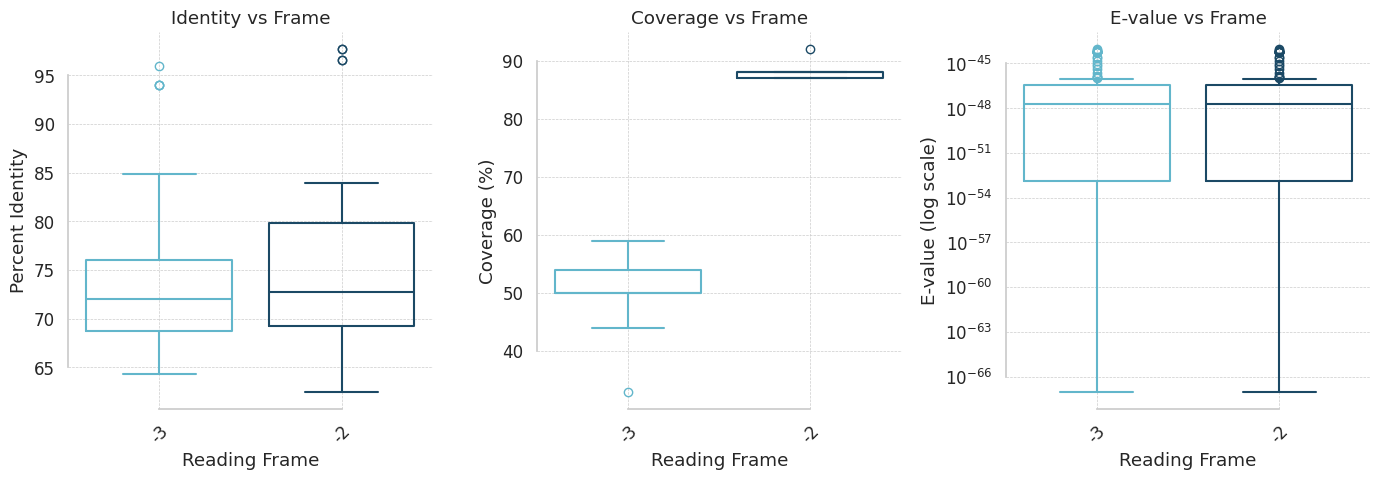

In [47]:
sns.set(style="whitegrid", context="notebook", font_scale=1.1)

f, axes = plt.subplots(1, 3, figsize=(14, 5))

sns.boxplot(
    data=df_data,
    y="Identity",
    x="Frame",
    ax=axes[0],
    palette=personalized_pallete[1:],
    fill=False
)
axes[0].set_title("Identity vs Frame")
axes[0].set_ylabel("Percent Identity")
axes[0].set_xlabel("Reading Frame")

sns.boxplot(
    data=df_data,
    y="Coverage",
    x="Frame",
    ax=axes[1],
    palette=personalized_pallete[1:],
    fill=False
)
axes[1].set_title("Coverage vs Frame")
axes[1].set_ylabel("Coverage (%)")
axes[1].set_xlabel("Reading Frame")

sns.boxplot(
    data=df_data,
    y="E-value",
    x="Frame",
    ax=axes[2],
    palette=personalized_pallete[1:],
    fill=False
)
axes[2].set_title("E-value vs Frame")
axes[2].set_ylabel("E-value (log scale)")
axes[2].set_xlabel("Reading Frame")
axes[2].set_yscale("log")

for ax in axes:
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

sns.despine(trim=True)
plt.tight_layout()


In [68]:
df_data_Frame2.describe()

,Identity,Coverage,E-value,Frame
count,99.000000,99.000000,9.900000e+01,99.0
mean,74.466444,87.737374,8.290272e-46,-2.0
std,7.780203,0.632227,2.113726e-45,0.0
min,62.500000,87.000000,9.790000e-68,-2.0
25%,69.142000,87.000000,1.510000e-53,-2.0
50%,72.727000,88.000000,2.360000e-48,-2.0
75%,79.545000,88.000000,3.430000e-47,-2.0
max,97.701000,92.000000,9.090000e-45,-2.0


In [69]:
df_data_Frame3.describe()

,Identity,Coverage,E-value,Frame
count,99.000000,99.000000,9.900000e+01,99.0
mean,72.906576,51.757576,8.290272e-46,-3.0
std,6.499537,3.188279,2.113726e-45,0.0
min,64.286000,33.000000,9.790000e-68,-3.0
25%,68.634500,50.000000,1.510000e-53,-3.0
50%,72.000000,50.000000,2.360000e-48,-3.0
75%,75.963000,54.000000,3.430000e-47,-3.0
max,96.000000,59.000000,9.090000e-45,-3.0


- Getting full sequences from alignment results

In [20]:
aligned_sequences = []

for record in SeqIO.parse("../external_results_tools/seqdump.txt", "fasta"):
    sequence = {"id_sequence" : record.id,
                "sequence" : str(record.seq),
                "description" : record.description}    
    aligned_sequences.append(sequence)

df_from_fasta = pd.DataFrame(aligned_sequences)
df_from_fasta

,id_sequence,sequence,description
0,XP_063603189.1,MAASMSLSSKLKKKAVRVKHQKVKLFRANEPFLSVFMWGVNHTSNE...,XP_063603189.1 phosphatidylinositol 5-phosphat...
1,XP_037774940.1,MAASMNLSSKLKKKAVRVKHQKVKLFRANEPFLSVFMWGVNHTSNE...,XP_037774940.1 phosphatidylinositol 5-phosphat...
2,XP_071522955.1,MASAASLSSKLKKKAVRVKHQKVKLFRANEPFLSVFMWGVNHTSSE...,XP_071522955.1 phosphatidylinositol 5-phosphat...
3,XP_069111413.1,MDKLKKERIRKVNPVSQKVKLFRASEPLLSVFMWGINHTINGLNHV...,XP_069111413.1 phosphatidylinositol 5-phosphat...
4,XP_033762842.1,MDKLKKERIRKVNPVSQKVKLFRASEPLLSVFMWGINHTINGLNHV...,XP_033762842.1 phosphatidylinositol 5-phosphat...
...,...,...,...
95,XP_055884806.1,MQVNELNNVNLRVMLMPDDFKSYSKIRVDNHMYNKDNMPSRFKVKE...,XP_055884806.1 phosphatidylinositol 5-phosphat...
96,XP_048756050.1,MEINTLNHVSIPVMLMPDDFKAFSKVHVDYHKFNKESMPSHFKFKE...,XP_048756050.1 phosphatidylinositol 5-phosphat...
97,KAG0423700.1,LPKQPSGGASSESGRVVINGLTHVNIPVMLMPDDFKSYTKIKVDNH...,KAG0423700.1 hypothetical protein HPB47_000545...
98,EEC11954.1,INGLTHVNIPVMLMPDDFKSYTKIKVDNHHFNKENMPSHFKVKEYC...,EEC11954.1 phosphatidylinositol-4-phosphate 5-...


- Merge data with fasta sequences

In [49]:
df_data_Frame2 = df_data_Frame2.merge(right=df_from_fasta, left_on="Accession", right_on="id_sequence")
df_data_Frame3 = df_data_Frame3.merge(right=df_from_fasta, left_on="Accession", right_on="id_sequence")

- Apply quality filters and remove

In [53]:
df_data_Frame3["to_ignore"] = df_data_Frame3["description"].apply(check_entres_to_ignore)
df_data_Frame2["to_ignore"] = df_data_Frame2["description"].apply(check_entres_to_ignore)

In [57]:
df_data_Frame2 = df_data_Frame2[df_data_Frame2["to_ignore"] == False]
df_data_Frame3 = df_data_Frame3[df_data_Frame3["to_ignore"] == False]

- Getting organism and subtypes

In [61]:
df_data_Frame2["Organism"] = df_data_Frame2["description"].apply(get_organism)
df_data_Frame3["Organism"] = df_data_Frame3["description"].apply(get_organism)

df_data_Frame2["Subtype"] = df_data_Frame2["description"].apply(get_subtype)
df_data_Frame3["Subtype"] = df_data_Frame3["description"].apply(get_subtype)

In [62]:
df_data_Frame2["Subtype"].value_counts()

Alpha    67
NA       25
Beta      7
Name: Subtype, dtype: int64

In [63]:
df_data_Frame3["Subtype"].value_counts()

Alpha    67
NA       25
Beta      7
Name: Subtype, dtype: int64

- Checking uniques id_sequence

In [64]:
print(df_data_Frame2["Accession"].unique().shape, 
      df_data_Frame3["Accession"].unique().shape)

(99,) (99,)


- Filter by statistics (Identity and Coverage)

In [70]:
df_data_Frame3.describe()

,Identity,Coverage,E-value,Frame
count,99.000000,99.000000,9.900000e+01,99.0
mean,72.906576,51.757576,8.290272e-46,-3.0
std,6.499537,3.188279,2.113726e-45,0.0
min,64.286000,33.000000,9.790000e-68,-3.0
25%,68.634500,50.000000,1.510000e-53,-3.0
50%,72.000000,50.000000,2.360000e-48,-3.0
75%,75.963000,54.000000,3.430000e-47,-3.0
max,96.000000,59.000000,9.090000e-45,-3.0


In [78]:
df_data_Frame3_filter = df_data_Frame3[(df_data_Frame3["Identity"]>=72.9) & (df_data_Frame3["Coverage"]>=51.75)]
df_data_Frame3_filter.shape

(10, 12)

In [73]:
df_data_Frame2.describe()

,Identity,Coverage,E-value,Frame
count,99.000000,99.000000,9.900000e+01,99.0
mean,74.466444,87.737374,8.290272e-46,-2.0
std,7.780203,0.632227,2.113726e-45,0.0
min,62.500000,87.000000,9.790000e-68,-2.0
25%,69.142000,87.000000,1.510000e-53,-2.0
50%,72.727000,88.000000,2.360000e-48,-2.0
75%,79.545000,88.000000,3.430000e-47,-2.0
max,97.701000,92.000000,9.090000e-45,-2.0


In [75]:
df_data_Frame2_filter = df_data_Frame2[(df_data_Frame2["Identity"]>=74.4) & (df_data_Frame2["Coverage"]>=87.73)]
df_data_Frame2_filter.shape

(17, 12)

- Reading translated sequences

In [22]:
translated_sequences = []

for record in SeqIO.parse("../external_results_tools/translate.txt", "fasta"):
    sequence = {"id_sequence" : record.id,
                "sequence" : str(record.seq),
                "description" : record.description}    
    translated_sequences.append(sequence)

df_translate = pd.DataFrame(translated_sequences)
df_translate

,id_sequence,sequence,description
0,5'3',SVQQCLGMSLYNVLVVLF-QVMHLFYFFTD-CFHKEFLILRHQHPG...,5'3' Frame 1
1,5'3',QFNSVWA-VSTMYWWYCFSR-CICSTSSLTSVFTKNFLS-DINIRA...,5'3' Frame 2
2,5'3',SSTVFGHESLQCTGGIVLAGDAFVLLLH-LVFSQRISYPETSTSGP...,5'3' Frame 3
3,3'5',YASNALGALPYGRPAGGREFTSDSLDVIGGGLIIR-MA-TM-TFL-...,3'5' Frame 1
4,3'5',MHPTRWELSHMVDLQAAANSLVIL-MSLVGD-SYDKWLEPCEPSCN...,3'5' Frame 2
5,3'5',CIQRVGSSPIWSTCRRPRIH--FSRCHWWGINHTINGLNHVNLPVM...,3'5' Frame 3


- As the alignment only show the frame -2 and -3, we will discard the rest of the frames

In [24]:
df_translate = df_translate[(df_translate["id_sequence"] == "3'5'") & (df_translate["description"] != "3'5' Frame 1")]
df_translate

,id_sequence,sequence,description
4,3'5',MHPTRWELSHMVDLQAAANSLVIL-MSLVGD-SYDKWLEPCEPSCN...,3'5' Frame 2
5,3'5',CIQRVGSSPIWSTCRRPRIH--FSRCHWWGINHTINGLNHVNLPVM...,3'5' Frame 3


- Preparing sequences for MSA

In [117]:
prepare_sequences_for_MSA(
    df_data_Frame2_filter, 
    df_translate["sequence"][4], 
    "[Frame2]A.purpuratus", 
    "../tmp/frame2.fasta")

prepare_sequences_for_MSA(
    df_data_Frame3_filter, 
    df_translate["sequence"][5], 
    "[Frame3]A.purpuratus", 
    "../tmp/frame3.fasta")


- Runing MSA

In [118]:
run_msa("../tmp/aligned_frame3.fasta", "../tmp/frame3.fasta")
run_msa("../tmp/aligned_frame2.fasta", "../tmp/frame2.fasta")

Running alignment...
Running alignment...


- Ploting Phylogenetic tree

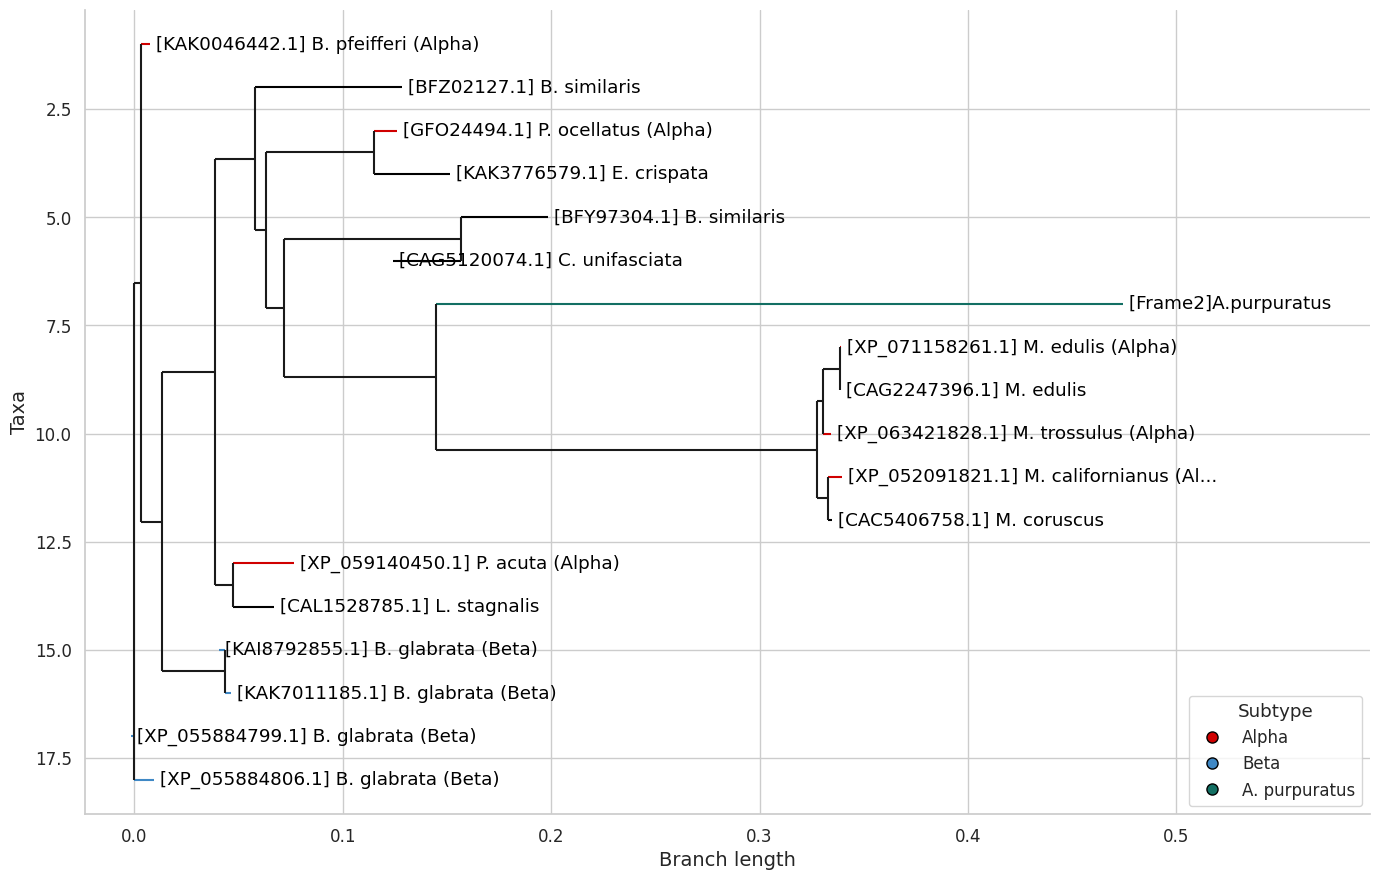

In [142]:
ploting_phylogenetic_tree("../tmp/aligned_frame2.fasta", "../figures_paper/phylogenetic_tree_frame2.svg")

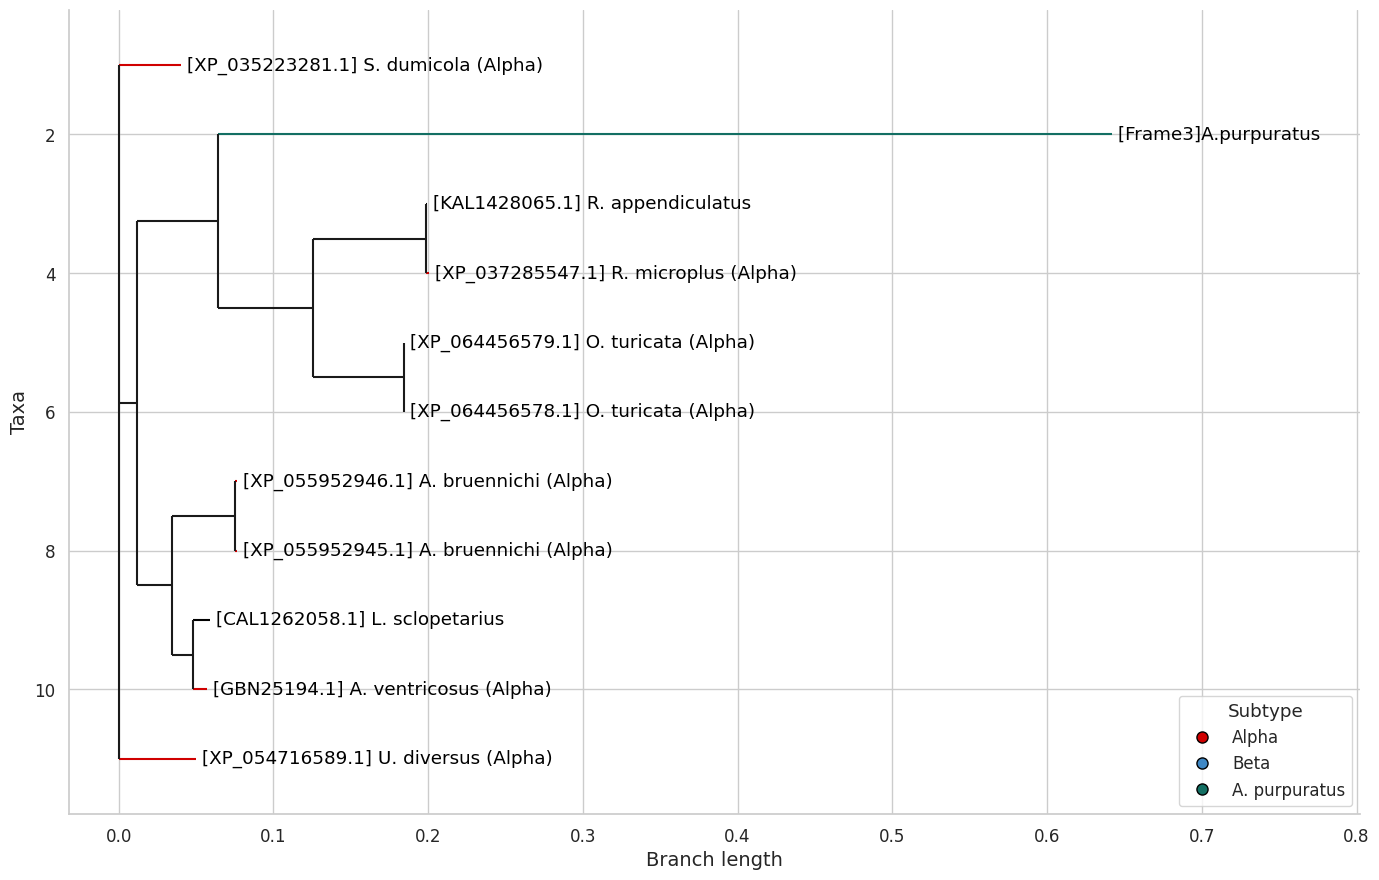

In [143]:
ploting_phylogenetic_tree("../tmp/aligned_frame3.fasta", "../figures_paper/phylogenetic_tree_frame3.svg")